### Workflow:

1. **Data Preparation**:
   - **Loading Data**: Load the grayscale images and corresponding labels from the provided directories (`DATA/samples` and `DATA/labels`).
   - **Normalization**: Normalize the pixel values of images and labels to bring them within a common scale, typically between 0 and 1. This ensures stable training and consistent behavior across different datasets.
   - **Dataset Splitting**: Split the dataset into training and validation sets to assess model performance. Common splitting ratios include 80-20 or 70-30 for training and validation, respectively.

2. **Model Development**:
   - **UNet Architecture**: Implement the UNet architecture, which consists of an encoder-decoder network with skip connections. This architecture is well-suited for semantic segmentation tasks, including membrane centerline detection.
   - **Custom Dataset Class**: Define a custom dataset class to handle loading and preprocessing of data. This class should inherit from PyTorch's `Dataset` class and implement methods like `__len__` and `__getitem__` for data access.
   - **Transformations**: Define transformations such as resizing, normalization, and conversion to tensors using `torchvision.transforms`. These transformations ensure data consistency and compatibility with the model.
   - **Data Loaders**: Initialize data loaders for training and validation datasets. Data loaders provide batch-wise access to the dataset, enabling efficient training with mini-batch gradient descent.

3. **Training**:
   - **Device Configuration**: Determine the device for computation based on availability (GPU or CPU). Use `torch.device` to set the device accordingly.
   - **Loss Function Selection**: Choose an appropriate loss function for the task. For membrane centerline detection, Binary Cross-Entropy Loss (`BCELoss`) is commonly used as it measures the similarity between predicted and ground truth masks.
   - **Optimizer Initialization**: Initialize an optimizer (Adam) to update the model parameters during training. Set the learning rate, which controls the step size of parameter updates.
   - **Learning Rate Scheduler**: Optionally, set up a learning rate scheduler to dynamically adjust the learning rate during training based on validation performance. This helps improve convergence and prevent overfitting.
   - **Training Loop**: Iterate over the training dataset for multiple epochs. Within each epoch, iterate over mini-batches of data, compute the loss, backpropagate gradients, and update model parameters using the optimizer.
   - **Model Checkpointing**: save the model weights periodically (after every few epochs) to resume training or evaluate later.

4. **Model Evaluation**:
   - **Validation Process**: Evaluate the trained model on the validation dataset to assess its performance.
   - **Loss and Metrics Calculation**: Compute the validation loss and additional evaluation metrics such as pixel accuracy, Intersection over Union (IoU), and Dice coefficient. These metrics provide insights into the model's ability to accurately detect membrane centerlines.

5. **Inference**:
   - **Load Pre-trained Model**: Load the pre-trained weights of the UNet model.
   - **Prepare Input Data**: Load or preprocess the new input images for membrane centerline detection.
   - **Perform Inference**: Pass the input images through the model to obtain predictions.

### Choice of UNet Architecture

The UNet architecture is chosen for several reasons:

1. **Semantic Segmentation**: UNet is well-suited for semantic segmentation tasks where pixel-level classification is required. In this case, we need to classify each pixel as membrane or background.

2. **U-Shape Architecture**: UNet's U-shaped architecture allows for capturing both local and global features through skip connections. This is beneficial for detecting membrane centerlines, as it requires understanding both local details and overall structure.

3. **Encoder-Decoder Design**: UNet's encoder-decoder design enables effective feature extraction and reconstruction, making it suitable for tasks where input and output sizes may differ.

4. **Previous Success**: UNet has been widely used and proven effective in various medical image segmentation tasks, including membrane detection. Its popularity and success in similar domains make it a suitable choice for this task as well.


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm.notebook import tqdm
import os
import numpy as np

### Image Processing and Transformation

1. **Load Image Paths**:
    - The script reads the paths of the sample images and their corresponding label images from specified directories.
2. **Define the `process_image` Function**:
    - This function takes an image name as input, loads the corresponding sample and label images, converts them to grayscale, resizes them to 64x64 pixels, and converts them to numpy arrays.
    - The function returns the processed sample and label images as numpy arrays.
3. **Initialize Multiprocessing**:
    - The script sets up multiprocessing to speed up the image processing by utilizing multiple CPU cores.
    - It creates a pool of worker processes and uses `tqdm` to display a progress bar.
4. **Process Images in Parallel**:
    - The script processes all sample images in parallel using the `process_image` function.
    - It collects the processed sample and label images into separate lists.
5. **Convert Lists to Numpy Arrays**:
    - After processing all images, the lists of sample and label images are converted to numpy arrays.
6. **Save the Numpy Arrays**:
    - Finally, the numpy arrays are saved to disk for later use.

### Note:
I ran this code on a local machine to generate .npy files. Later, I uploaded the generated .npy files to Google Drive and utilized them for further implementation.



In [ ]:
import os
from PIL import Image,  ImageOps
from tqdm import tqdm
from multiprocessing import Pool
import numpy as np

samples = os.listdir("C:/Users/rushi/OneDrive/Desktop/DATA/samples")
label_path = "C:/Users/rushi/OneDrive/Desktop/DATA/labels"
sample_path = "C:/Users/rushi/OneDrive/Desktop/DATA/samples"
save_path = 'transformed_samples'

def process_image(image_name):
        label_name = f'label_{image_name.split("_")[-1]}'

        image_gray = Image.open(os.path.join(sample_path, image_name))
        label_gray = Image.open(os.path.join(label_path, label_name))
        label_gray = ImageOps.grayscale(label_gray)

        image_np = np.array(image_gray.convert("RGB").resize((64, 64)))
        label_np = np.array(label_gray.resize((64, 64)))

        if image_np.shape != (64, 64, 3) or label_np.shape != (64, 64):
            print(image_np.shape)
            print(label_np.shape)

        return image_np, label_np

if __name__ == '__main__':
    samples = os.listdir("C:/Users/rushi/OneDrive/Desktop/DATA/samples")
    label_path = "C:/Users/rushi/OneDrive/Desktop/DATA/labels"
    sample_path = "C:/Users/rushi/OneDrive/Desktop/DATA/samples"
    save_path = 'transformed_samples'

    num_processes = 4

    samples_array = []
    labels_array = []

    # Define the pool for multiprocessing
    with Pool(processes=num_processes) as pool:
        for image_np, label_np in tqdm(pool.imap_unordered(process_image, samples), total=len(samples)):
            samples_array.append(image_np)
            labels_array.append(label_np)

    # Convert lists to numpy arrays
    samples_array = np.array(samples_array)
    labels_array = np.array(labels_array)

    # Save the arrays
    np.save(os.path.join('samples_2.npy'), samples_array)
    np.save(os.path.join('labels_2.npy'), labels_array)


### Membrane Dataset and DataLoader Initialization

This script sets up a custom dataset class and prepares data loaders for training and validation of a neural network model.

#### Importing Libraries

- **os**: Provides functions to interact with the operating system.
- **numpy**: Used for array manipulations.
- **torch**: Core PyTorch library for tensor operations.
- **torch.utils.data**: Provides utilities for data handling.
- **torchvision.transforms**: Provides common image transformations.

#### Custom Dataset Class

- **MembraneDataset Class**: A custom dataset class derived from `torch.utils.data.Dataset`.
  - **__init__**:
    - Loads the samples and labels from the provided numpy files.
    - Filters out any sample-label pairs that are lists (ensuring they are arrays).
    - Stores the filtered samples and labels.
    - Takes an optional transform parameter.
  - **__len__**: Returns the total number of samples.
  - **__getitem__**:
    - Normalizes the sample images by scaling pixel values to a specific range.
    - Normalizes the label images to a range between 0 and 1.
    - Returns the sample and label as float32 tensors with appropriate reshaping.

#### Defining Transformations

- **Transformations**: Converts images to PyTorch tensors.

#### File Paths

- **samples_file**: Path to the numpy file containing sample images.
- **labels_file**: Path to the numpy file containing label images.

#### Initialize Dataset

- **Initialize Dataset**: Creates an instance of the `MembraneDataset` class with the specified file paths and transformations.

#### Split Data into Training and Validation Sets

- **Splitting Data**:
  - Calculates the total number of samples.
  - Defines the size of the training set (80% of total samples).
  - Defines the size of the validation set (20% of total samples).
  - Splits the dataset into training and validation sets using `torch.utils.data.random_split`.

#### Define DataLoaders for Training and Validation

- **DataLoaders**:
  - **train_loader**: Loads the training data in batches of 64, shuffling the data to ensure randomness.
  - **val_loader**: Loads the validation data in batches of 64, without shuffling to maintain order.

This is essential for efficiently training and validating a neural network model using the MembraneDataset, ensuring data is properly loaded, transformed, and split into training and validation sets.


In [2]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class MembraneDataset(Dataset):
    def __init__(self, samples_file, labels_file, transform=None):
        self.samples = np.load(samples_file)
        self.labels = np.load(labels_file)

        samples_labels = [(sample, label) for sample, label in zip(self.samples, self.labels) if (type(sample)!=list and type(label)!=list)]
        self.samples, self.labels = zip(*samples_labels)

        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        label = self.labels[idx]
        sample = (sample - 150) / (1000 - 150)
        label = label/255                              # 255 max
        return sample.astype(np.float32).reshape((3,64,64))[:1, :, :] , label.astype(np.float32).reshape((1, 64, 64))

# Transformations
transform = transforms.Compose([
    transforms.ToTensor(),
])

samples_file = "/content/drive/MyDrive/Coop_Data/samples_2.npy"
labels_file = "/content/drive/MyDrive/Coop_Data/labels_2.npy"

dataset = MembraneDataset(samples_file, labels_file, transform=transform)

# Split data into train and validation sets
total_samples = len(dataset)
train_size = int(0.8 * total_samples)
val_size = total_samples - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# DataLoader for training
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# DataLoader for validation
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


### Setting Up Device for Computation
This cell sets up the device for computation, determining whether to use a GPU (if available) or fallback to the CPU.

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

This cell implements a UNet architecture.

1. **Double Convolutional Block**:
   - The `double_conv` function creates a sequence of two convolutional layers followed by ReLU activation functions. It forms the basic building block used in the UNet architecture.

2. **UNet Class**:
   - The `UNet` class inherits from `nn.Module` and defines the UNet architecture.
   - It comprises down-sampling (encoder) and up-sampling (decoder) paths with skip connections between corresponding layers.
   - Down-sampling blocks (`dconv_down1` to `dconv_down4`) reduce spatial dimensions using convolution and max-pooling operations.
   - Up-sampling blocks (`dconv_up1` to `dconv_up3`) increase spatial dimensions using convolution and up-sampling operations.
   - The last convolutional layer (`conv_last`) outputs the final segmentation map with a specified number of classes.
   - A sigmoid activation function (`sigmoid`) is applied to ensure pixel-wise values are between 0 and 1.

3. **Forward Method**:
   - The `forward` method defines how input data flows through the network.
   - It passes input through down-sampling blocks, then up-sampling blocks with skip connections.
   - Finally, the output is obtained by applying the last convolutional layer followed by a sigmoid activation function.


In [5]:
import torch
import torch.nn as nn

def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )

class UNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()

        self.dconv_down1 = double_conv(1, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)

        self.conv_last = nn.Conv2d(64, n_class, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)

        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)

        x = self.dconv_down4(x)

        x = self.upsample(x)
        x = torch.cat([x, conv3], dim=1)

        x = self.dconv_up3(x)
        x = self.upsample(x)
        x = torch.cat([x, conv2], dim=1)

        x = self.dconv_up2(x)
        x = self.upsample(x)
        x = torch.cat([x, conv1], dim=1)

        x = self.dconv_up1(x)

        out = self.conv_last(x)
        out = self.sigmoid(out)
        return out

### 1. Model and Training Setup

- **Directory Path Definition**:
  - `weight_path` variable holds the directory path where the model weights will be saved. This ensures easy access to saved weights.

- **Device Configuration**:
  - The code checks for GPU availability with `torch.cuda.is_available()`. If a GPU is available, the device is set to GPU (`cuda`); otherwise, it falls back to CPU (`cpu`).
  - This ensures that the model can utilize GPU acceleration if available, which typically speeds up the training process.

- **Model Initialization**:
  - An instance of the UNet model is created (`UNet(1)`) for semantic segmentation tasks where there's one output channel (e.g., binary segmentation).
  - The model is then moved to the selected device (`model.to(device)`) to ensure that model computations are performed on the chosen hardware.

### 2. Loss Function, Optimizer, and Epochs

- **Loss Function Selection**:
  - Binary Cross-Entropy Loss (`BCELoss`) is chosen as the loss function (`criterion`) for the training process.
  - BCELoss is commonly used for binary classification tasks like image segmentation, where each pixel is classified into one of two classes (foreground or background).

- **Optimizer Configuration**:
  - Adam optimizer is selected (`optim.Adam`) for parameter optimization.
  - The learning rate is set to 0.0001, a commonly used value that balances training speed and convergence stability.

- **Epochs Definition**:
  - The number of training epochs is set to 50 (`epochs`), determining the number of complete passes through the entire training dataset during training.

### 3. Learning Rate Scheduler

- **Scheduler Initialization**:
  - A scheduler (`ReduceLROnPlateau`) is initialized to dynamically adjust the learning rate during training based on the validation loss.
  - The scheduler monitors the minimum mode of the loss, reducing the learning rate (`factor=0.25`) if the validation loss does not improve for a certain number of epochs (`patience=2`).

### 4. Training Loop

- **Epoch-wise Training Loop**:
  - The code iterates over each epoch of training using a `for` loop.
  - Within each epoch, the model is set to training mode (`model.train()`) to enable training-specific behavior like dropout.
  - Training data is processed in mini-batches using a data loader (`train_loader`), where gradients are computed, and model parameters are updated based on the computed loss.
  - The training loss for each epoch is computed as the average loss over all mini-batches and printed.

### 5. Model Checkpointing

- **Periodic Model Saving**:
  - After every 2 epochs (`if (epoch + 1) % 2 == 0`), the model weights are saved to the specified directory (`weight_path`) using `torch.save`.
  - The file name includes the epoch number to distinguish between different model snapshots saved during training.


In [32]:
weight_path = '/content/drive/MyDrive/Coop_Data/ModelWeights/'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(1)
model.to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
epochs = 50

# Scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.25, patience=2, verbose=True)

for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0
    pbar = tqdm(total=len(train_loader))
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        pbar.set_postfix(loss=loss.item())
        pbar.update(1)
    scheduler.step(epoch_loss)
    pbar.close()
    print(f"Epoch {epoch+1}/{epochs}, Training Loss: {epoch_loss/len(train_loader)}")

    # To Save model weights after every 2 epochs
    if (epoch + 1) % 2 == 0:
        model_save_path = os.path.join(weight_path, f'model_epoch_{epoch+1}.pth')
        torch.save(model.state_dict(), model_save_path)
        print(f'Model weights saved for epoch {epoch+1} at {model_save_path}')

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


  0%|          | 0/358 [00:00<?, ?it/s]

Epoch 1/50, Training Loss: 0.15474520024307614


  0%|          | 0/358 [00:00<?, ?it/s]

Epoch 2/50, Training Loss: 0.11875104885444294
Model weights saved for epoch 2 at /content/drive/MyDrive/Coop_Data/ModelWeights/model_epoch_2.pth


  0%|          | 0/358 [00:00<?, ?it/s]

Epoch 3/50, Training Loss: 0.10811032236205133


  0%|          | 0/358 [00:00<?, ?it/s]

Epoch 4/50, Training Loss: 0.09468835656786098
Model weights saved for epoch 4 at /content/drive/MyDrive/Coop_Data/ModelWeights/model_epoch_4.pth


  0%|          | 0/358 [00:00<?, ?it/s]

Epoch 5/50, Training Loss: 0.08409782696785874


  0%|          | 0/358 [00:00<?, ?it/s]

Epoch 6/50, Training Loss: 0.07732694720922235
Model weights saved for epoch 6 at /content/drive/MyDrive/Coop_Data/ModelWeights/model_epoch_6.pth


  0%|          | 0/358 [00:00<?, ?it/s]

Epoch 7/50, Training Loss: 0.07223755788245348


  0%|          | 0/358 [00:00<?, ?it/s]

Epoch 8/50, Training Loss: 0.06855434663177536
Model weights saved for epoch 8 at /content/drive/MyDrive/Coop_Data/ModelWeights/model_epoch_8.pth


  0%|          | 0/358 [00:00<?, ?it/s]

Epoch 9/50, Training Loss: 0.06544169411063194


  0%|          | 0/358 [00:00<?, ?it/s]

Epoch 10/50, Training Loss: 0.0630293986942182
Model weights saved for epoch 10 at /content/drive/MyDrive/Coop_Data/ModelWeights/model_epoch_10.pth


  0%|          | 0/358 [00:00<?, ?it/s]

Epoch 11/50, Training Loss: 0.06101761379554951


  0%|          | 0/358 [00:00<?, ?it/s]

Epoch 12/50, Training Loss: 0.0591191179925503
Model weights saved for epoch 12 at /content/drive/MyDrive/Coop_Data/ModelWeights/model_epoch_12.pth


  0%|          | 0/358 [00:00<?, ?it/s]

Epoch 13/50, Training Loss: 0.057501873771488334


  0%|          | 0/358 [00:00<?, ?it/s]

Epoch 14/50, Training Loss: 0.055531251030927264
Model weights saved for epoch 14 at /content/drive/MyDrive/Coop_Data/ModelWeights/model_epoch_14.pth


  0%|          | 0/358 [00:00<?, ?it/s]

Epoch 15/50, Training Loss: 0.05372320555733236


  0%|          | 0/358 [00:00<?, ?it/s]

Epoch 16/50, Training Loss: 0.052150945059497265
Model weights saved for epoch 16 at /content/drive/MyDrive/Coop_Data/ModelWeights/model_epoch_16.pth


  0%|          | 0/358 [00:00<?, ?it/s]

Epoch 17/50, Training Loss: 0.05059794122197109


  0%|          | 0/358 [00:00<?, ?it/s]

Epoch 18/50, Training Loss: 0.049310364432674544
Model weights saved for epoch 18 at /content/drive/MyDrive/Coop_Data/ModelWeights/model_epoch_18.pth


  0%|          | 0/358 [00:00<?, ?it/s]

Epoch 19/50, Training Loss: 0.04809419500677945


  0%|          | 0/358 [00:00<?, ?it/s]

Epoch 20/50, Training Loss: 0.046861383356362085
Model weights saved for epoch 20 at /content/drive/MyDrive/Coop_Data/ModelWeights/model_epoch_20.pth


  0%|          | 0/358 [00:00<?, ?it/s]

Epoch 21/50, Training Loss: 0.045744714821433885


  0%|          | 0/358 [00:00<?, ?it/s]

Epoch 22/50, Training Loss: 0.04462142278279006
Model weights saved for epoch 22 at /content/drive/MyDrive/Coop_Data/ModelWeights/model_epoch_22.pth


  0%|          | 0/358 [00:00<?, ?it/s]

Epoch 23/50, Training Loss: 0.04362665339471908


  0%|          | 0/358 [00:00<?, ?it/s]

Epoch 24/50, Training Loss: 0.042719574478668206
Model weights saved for epoch 24 at /content/drive/MyDrive/Coop_Data/ModelWeights/model_epoch_24.pth


  0%|          | 0/358 [00:00<?, ?it/s]

Epoch 25/50, Training Loss: 0.04163041441342351


  0%|          | 0/358 [00:00<?, ?it/s]

Epoch 26/50, Training Loss: 0.04055370748376047
Model weights saved for epoch 26 at /content/drive/MyDrive/Coop_Data/ModelWeights/model_epoch_26.pth


  0%|          | 0/358 [00:00<?, ?it/s]

Epoch 27/50, Training Loss: 0.039648583710360126


  0%|          | 0/358 [00:00<?, ?it/s]

Epoch 28/50, Training Loss: 0.0388409312887315
Model weights saved for epoch 28 at /content/drive/MyDrive/Coop_Data/ModelWeights/model_epoch_28.pth


  0%|          | 0/358 [00:00<?, ?it/s]

Epoch 29/50, Training Loss: 0.03804391208911242


  0%|          | 0/358 [00:00<?, ?it/s]

Epoch 30/50, Training Loss: 0.037233122005309476
Model weights saved for epoch 30 at /content/drive/MyDrive/Coop_Data/ModelWeights/model_epoch_30.pth


  0%|          | 0/358 [00:00<?, ?it/s]

Epoch 31/50, Training Loss: 0.036510727893790056


  0%|          | 0/358 [00:00<?, ?it/s]

Epoch 32/50, Training Loss: 0.03578183464914061
Model weights saved for epoch 32 at /content/drive/MyDrive/Coop_Data/ModelWeights/model_epoch_32.pth


  0%|          | 0/358 [00:00<?, ?it/s]

Epoch 33/50, Training Loss: 0.03493263468396064


  0%|          | 0/358 [00:00<?, ?it/s]

Epoch 34/50, Training Loss: 0.034230450069396526
Model weights saved for epoch 34 at /content/drive/MyDrive/Coop_Data/ModelWeights/model_epoch_34.pth


  0%|          | 0/358 [00:00<?, ?it/s]

Epoch 35/50, Training Loss: 0.03356015902824242


  0%|          | 0/358 [00:00<?, ?it/s]

Epoch 36/50, Training Loss: 0.03303194707311565
Model weights saved for epoch 36 at /content/drive/MyDrive/Coop_Data/ModelWeights/model_epoch_36.pth


  0%|          | 0/358 [00:00<?, ?it/s]

Epoch 37/50, Training Loss: 0.03238399167591966


  0%|          | 0/358 [00:00<?, ?it/s]

Epoch 38/50, Training Loss: 0.03180739324144478
Model weights saved for epoch 38 at /content/drive/MyDrive/Coop_Data/ModelWeights/model_epoch_38.pth


  0%|          | 0/358 [00:00<?, ?it/s]

Epoch 39/50, Training Loss: 0.031225164831933362


  0%|          | 0/358 [00:00<?, ?it/s]

Epoch 40/50, Training Loss: 0.03067180737540875
Model weights saved for epoch 40 at /content/drive/MyDrive/Coop_Data/ModelWeights/model_epoch_40.pth


  0%|          | 0/358 [00:00<?, ?it/s]

Epoch 41/50, Training Loss: 0.030192724111692864


  0%|          | 0/358 [00:00<?, ?it/s]

Epoch 42/50, Training Loss: 0.029824415612029295
Model weights saved for epoch 42 at /content/drive/MyDrive/Coop_Data/ModelWeights/model_epoch_42.pth


  0%|          | 0/358 [00:00<?, ?it/s]

Epoch 43/50, Training Loss: 0.029117106043801293


  0%|          | 0/358 [00:00<?, ?it/s]

Epoch 44/50, Training Loss: 0.028804854453442483
Model weights saved for epoch 44 at /content/drive/MyDrive/Coop_Data/ModelWeights/model_epoch_44.pth


  0%|          | 0/358 [00:00<?, ?it/s]

Epoch 45/50, Training Loss: 0.028514595176795676


  0%|          | 0/358 [00:00<?, ?it/s]

Epoch 46/50, Training Loss: 0.028005406218867063
Model weights saved for epoch 46 at /content/drive/MyDrive/Coop_Data/ModelWeights/model_epoch_46.pth


  0%|          | 0/358 [00:00<?, ?it/s]

Epoch 47/50, Training Loss: 0.027694587642587098


  0%|          | 0/358 [00:00<?, ?it/s]

Epoch 48/50, Training Loss: 0.02737121814185514
Model weights saved for epoch 48 at /content/drive/MyDrive/Coop_Data/ModelWeights/model_epoch_48.pth


  0%|          | 0/358 [00:00<?, ?it/s]

Epoch 49/50, Training Loss: 0.02711436488566785


  0%|          | 0/358 [00:00<?, ?it/s]

Epoch 50/50, Training Loss: 0.026726030926714398
Model weights saved for epoch 50 at /content/drive/MyDrive/Coop_Data/ModelWeights/model_epoch_50.pth


## Model Evaluation Metrics

### Pixel Accuracy

- **Description**:
  - Computes the pixel accuracy between ground truth (`y_true`) and predicted (`y_pred`) binary segmentation masks.

- **Implementation**:
  - Predictions are rounded to convert probabilities to binary values.
  - Number of correct predictions is calculated, and pixel accuracy is computed as the ratio of correct predictions to the total number of pixels.

### Intersection over Union (IoU) Coefficient

- **Description**:
  - Computes the Intersection over Union (IoU) metric between ground truth (`y_true`) and predicted (`y_pred`) binary segmentation masks.

- **Implementation**:
  - Predictions are rounded to convert probabilities to binary values.
  - Intersection and union of the masks are calculated, and IoU is computed using the formula: (intersection + smooth) / (union + smooth), where `smooth` is added to avoid division by zero.

### Dice Coefficient

- **Description**:
  - Computes the Dice coefficient metric between ground truth (`y_true`) and predicted (`y_pred`) binary segmentation masks.

- **Implementation**:
  - Predictions are rounded to convert probabilities to binary values.
  - Intersection and union of the masks are calculated, and Dice coefficient is computed using the formula: (2 * intersection + smooth) / (union + smooth), where `smooth` is added to avoid division by zero.


In [35]:
# model evaluation Metrics
def pixel_accuracy(y_true, y_pred):
    y_pred = torch.round(y_pred)
    correct = torch.eq(y_true, y_pred).int()
    accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

def iou_coef(y_true, y_pred, smooth=1):
    y_pred = torch.round(y_pred)
    intersection = torch.sum(y_true * y_pred)
    union = torch.sum(y_true) + torch.sum(y_pred) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou.item()

def dice_coef(y_true, y_pred, smooth=0.01):
    y_pred = torch.round(y_pred)
    intersection = torch.sum(y_true * y_pred)
    union = torch.sum(y_true) + torch.sum(y_pred)
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice.item()

### Load pre-trained weights into the UNet model
This code snippet loads pre-trained weights into the UNet model from the specified path (`model_weights_path`). The model is then set to evaluation mode, indicating that it will be used for inference rather than training.

In [1]:
# import torch

# model_weights_path = '/content/drive/MyDrive/Coop_Data/ModelWeights/model_epoch_2.pth'
# model = UNet(1)
# model.to(device)

# Load the weights into the model
# model.load_state_dict(torch.load(model_weights_path))

# model.eval()

## Model Validation


- The model is moved to the specified device (`device`) and set to evaluation mode (`model.eval()`).
- Variables are initialized to store validation loss (`val_loss`) and evaluation metrics such as pixel accuracy (`pixel_acc`), Intersection over Union (IoU) (`iou`), and Dice coefficient (`dice`).
- Binary Cross-Entropy Loss (`BCELoss`) is chosen as the loss function (`criterion`).
- The number of batches in the validation dataset is determined (`num_batches`).
- A loop iterates over each batch of validation data, where inputs and labels are moved to the device.
- Predictions are obtained from the model for the current batch.
- Validation loss is accumulated.
- Pixel accuracy, IoU, and Dice coefficient are computed and accumulated.
- Final validation metrics are calculated by averaging over all batches.
- Validation loss, pixel accuracy, IoU, and Dice coefficient are printed to the console.


In [40]:
# Model Validation
model.to(device)
model.eval()
val_loss = 0.0
pixel_acc = 0.0
iou = 0.0
dice = 0.0
criterion = nn.BCELoss()
num_batches = len(val_loader)
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        with torch.no_grad():
            outputs = model(inputs)
        val_loss += criterion(outputs, labels).item()
        pixel_acc += pixel_accuracy(labels, outputs)
        iou += iou_coef(labels, outputs)
        dice += dice_coef(labels, outputs)
val_loss /= num_batches
pixel_acc /= num_batches
iou /= num_batches
dice /= num_batches
print(f"Validation Loss: {val_loss}, \nPixel Accuracy: {pixel_acc}, \nIoU: {iou}, \nDice Coefficient: {dice}")

Validation Loss: 0.05200348897940583, 
Pixel Accuracy: 0.9582466357925031, 
IoU: 0.5687640766302745, 
Dice Coefficient: 0.7248729050159455


### Image Visualization:
**Visualization Process**:
  - The trained model is set to evaluation mode.
  - Input images, ground truth labels, and model predictions are collected during the validation loop.
  - Random samples are selected for visualization.
  - Input images, labels, and model predictions are plotted side by side using Matplotlib.

**Intent**:
  - The code aims to provide a quick visual assessment of the model's performance on the validation dataset.
  - It helps in understanding how well the model's predictions align with the ground truth labels.
  - Visual inspection facilitates identifying potential discrepancies or errors in the model's predictions.


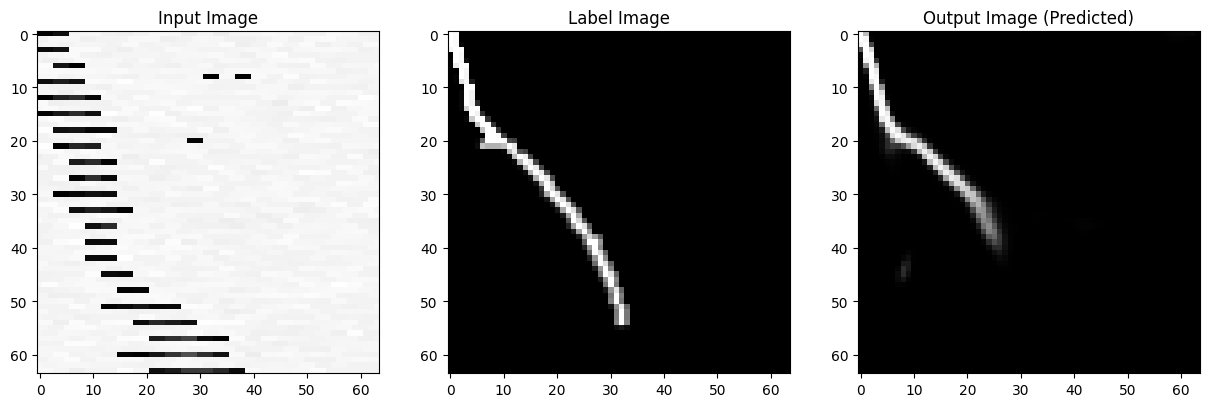

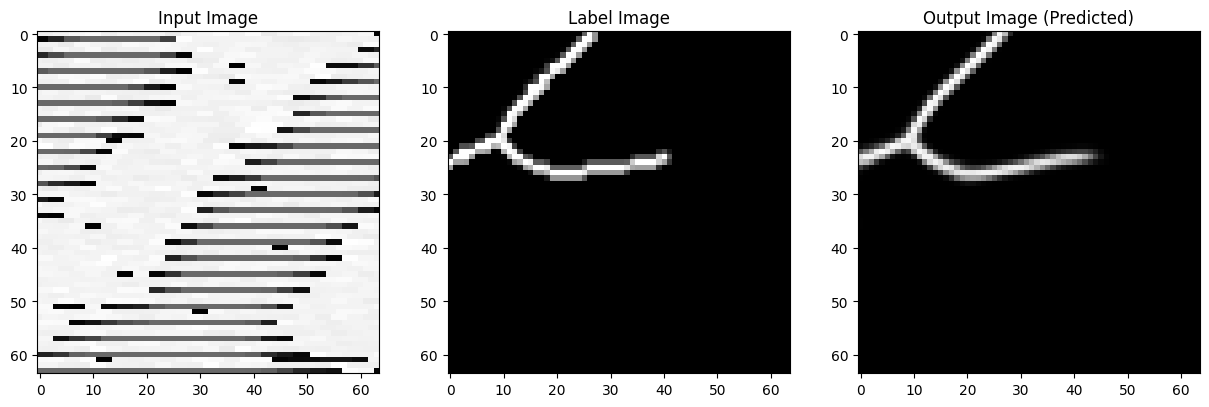

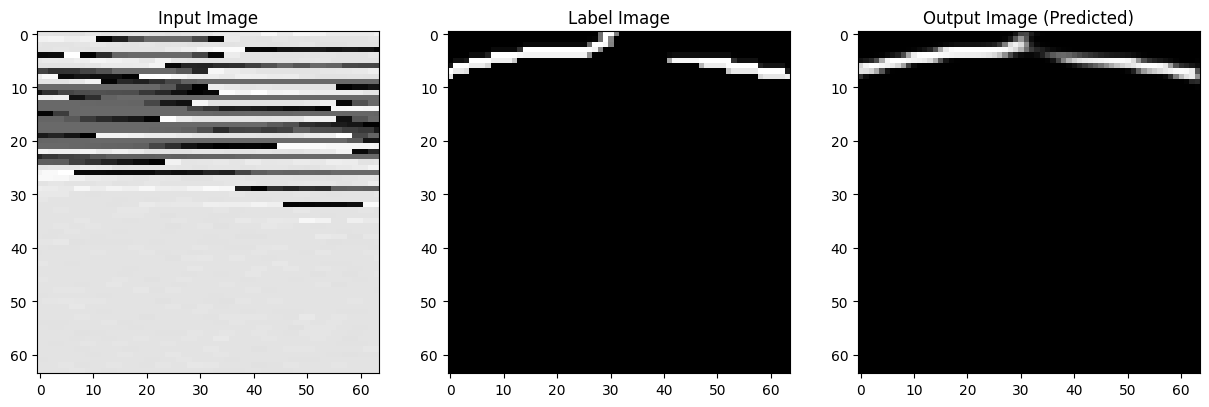

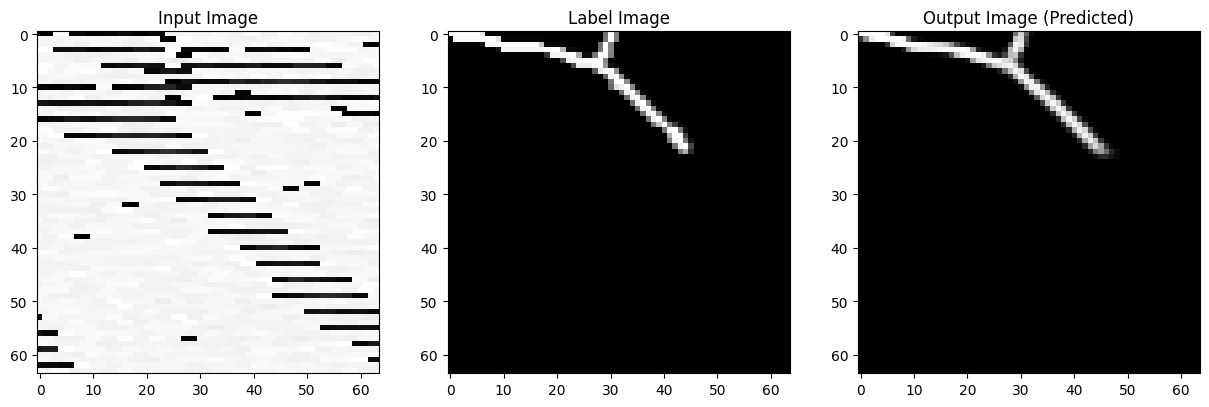

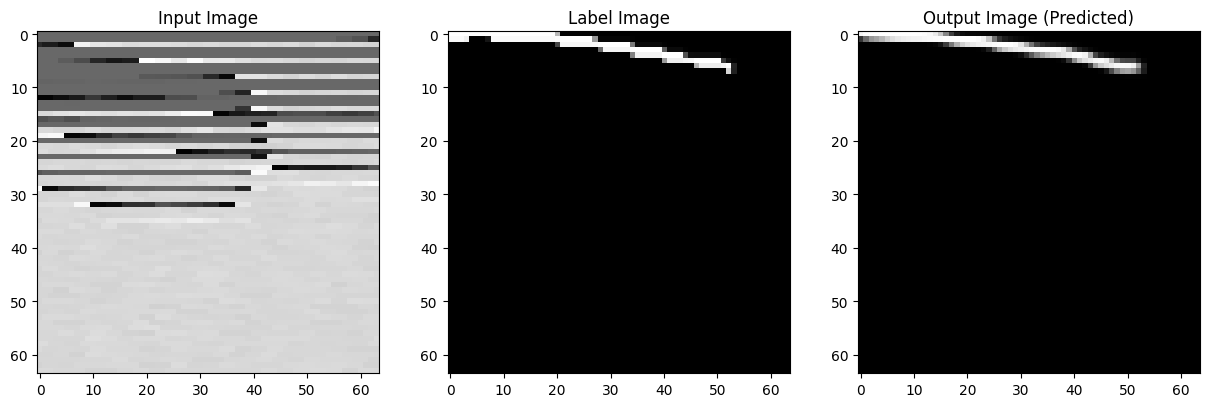

In [37]:
import matplotlib.pyplot as plt
import numpy as np

model.eval()

visualized_inputs = []
visualized_labels = []
visualized_outputs = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)

        # Convert tensors to numpy arrays
        inputs_np = inputs.cpu().numpy()
        labels_np = labels.cpu().numpy()
        outputs_np = outputs.cpu().numpy()

        visualized_inputs.extend(inputs_np)
        visualized_labels.extend(labels_np)
        visualized_outputs.extend(outputs_np)

num_visualized = 5

# Shuffle indices and select random images
total_images = len(visualized_inputs)
indices = np.random.permutation(total_images)[:num_visualized]

# Visualize the images
for i in indices:
    input_image = visualized_inputs[i][0]
    label_image = visualized_labels[i][0]
    output_image = visualized_outputs[i][0]

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(input_image, cmap='gray')
    plt.title('Input Image')

    plt.subplot(1, 3, 2)
    plt.imshow(label_image, cmap='gray')
    plt.title('Label Image')

    plt.subplot(1, 3, 3)
    plt.imshow(output_image, cmap='gray')
    plt.title('Output Image (Predicted)')

    plt.show()
